# Brain Tumor MRIs Segmentation Masks vs CNN Grad-cam ++ Saliency Masks : 

# *Which Texture Features For Each Tumor Image Will Potential Radiomic Biomarkers Show Up?*

Used Datasets : • Masoud Nickparvar, Kaggle Brain Tumor Dataset, 2020.
                • SciDB Brain Tumor Dataset, SciDB, 2021.
Indrakumar K, and Ravikumar M. (2025). Brain Tumor Dataset: Segmentation & Classification [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/11957028

### Firstly, install dependencies...

In [1]:
!pip install pyradiomics
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 45.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 57.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyradiomics: filename=pyradiomics-3.0.1-cp311-cp311-linux_x86_64.whl size=169811 sha256=ec85fe308cdc94a6a2aa189d703d1c824677382d4dd519bd08ccd1b276f27b63
  Stored i

### And load the imports...

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import SimpleITK as sitk
from radiomics import featureextractor
from sklearn.feature_selection import VarianceThreshold, f_classif
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
import shap
from keras.models import Sequential 
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.metrics import Accuracy, Precision, F1Score
from keras.models import Model 
import random
import os
import seaborn as sns
from scipy import stats
from scipy.stats import wilcoxon
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-12-03 04:23:31.177296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764735811.407777      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764735811.470958      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

This segmentation dataset contains three types of brain tumors : glioma, meningioma, and pituitary. Each mask per image has already beem provided, where Pyradiomics's feature extractor will only focus on that masked region of the tumor (not focused on the background of the image), and find interesting biological details about its texture surrounding the region.

**This imaging dataset has already been preprocessed to have noise reduction and is normalized.**

class_name
Pituitary tumor    1860
Meningioma         1416
Glioma             1108
Name: count, dtype: int64


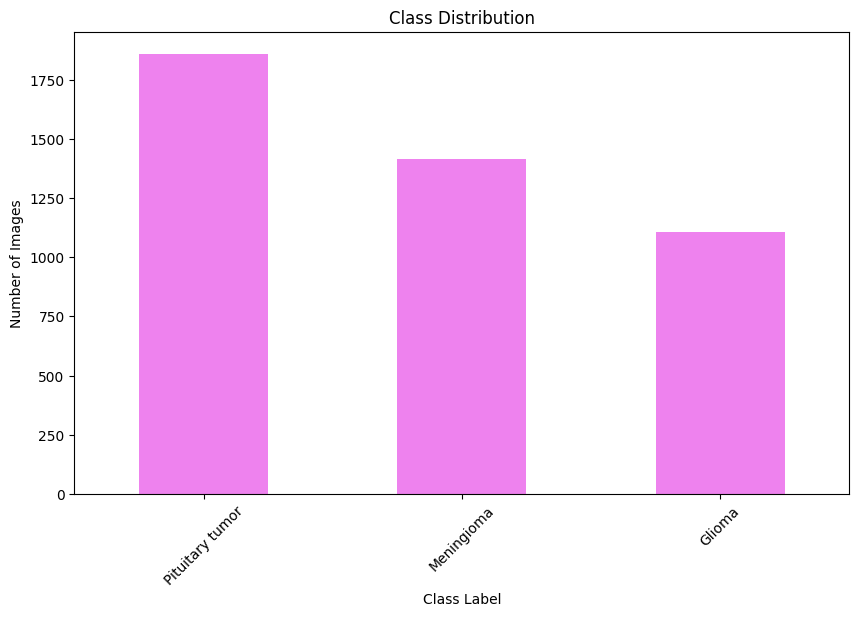

In [3]:
csv_file = "/kaggle/input/brain-tumor-classes/tumor_segment.csv"

data = pd.read_csv(csv_file)

class_distribution = data['class_name'].value_counts()
print(class_distribution)

plt.figure(figsize=(10,6))
class_distribution.plot(kind = 'bar', color='violet')
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel("Number of Images")
plt.xticks(rotation = 45)
plt.show()

In [4]:
data.head()

image_path  unique_id  \
0  /kaggle/input/brain-tumor-dataset-segmentation...       1970   
1  /kaggle/input/brain-tumor-dataset-segmentation...        439   
2  /kaggle/input/brain-tumor-dataset-segmentation...       1899   
3  /kaggle/input/brain-tumor-dataset-segmentation...       3536   
4  /kaggle/input/brain-tumor-dataset-segmentation...       3255   

        class_name  class_id  
0       Meningioma         1  
1  Pituitary tumor         0  
2       Meningioma         1  
3           Glioma         2  
4       Meningioma         1

#### **An example of a 2D Glioma tumor and its designated segmentation mask :**

<function matplotlib.pyplot.show(close=None, block=None)>

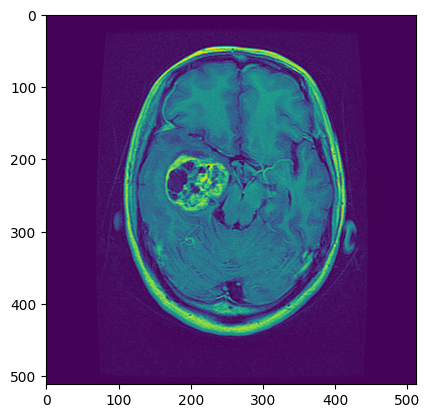

In [5]:
image_path_mri = "/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation/Glioma/enh_1841.png"
image_path_mask = "/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation/Glioma/enh_1841_mask.png"

img_mri = Image.open(image_path_mri)
img_mask = Image.open(image_path_mask)

plt.imshow(img_mri)    #MRI example
plt.axis('on')
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

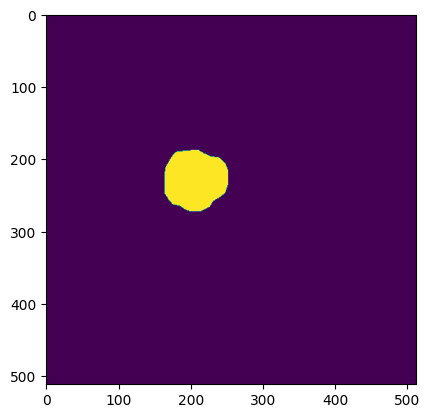

In [6]:
plt.imshow(img_mask)
plt.axis('on')        #Mask example
plt.show

## Now lets extract those texture features from all of these masks from the dataset...

In [7]:
seg_dir = "/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation"
tumors = ["Glioma", "Meningioma", "Pituitary tumor"] #What the folders say...

extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures() 
seg_images = []

for tumor in tumors:
    folder_path = os.path.join(seg_dir, tumor)

    for file in os.listdir(folder_path):
        if "mask" in file:  
            continue

        img_path = os.path.join(folder_path, file)
        mask_path = os.path.join(folder_path, file.replace('.png', '_mask.png'))
        image = sitk.ReadImage(img_path)
        mask = sitk.ReadImage(mask_path)
       
        feature_vector = extractor.execute(image, mask, label = 255) #Change size to 255 pixels
      
        feature_vector["tumor_type"] = tumor
        feature_vector["file_name"] = file
        seg_images.append(feature_vector) #Vectors

seg_images_df = pd.DataFrame(seg_images)

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

In [8]:
seg_images_df.head()

diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                           v3.0.1                     1.26.4   
1                           v3.0.1                     1.26.4   
2                           v3.0.1                     1.26.4   
3                           v3.0.1                     1.26.4   
4                           v3.0.1                     1.26.4   

  diagnostics_Versions_SimpleITK diagnostics_Versions_PyWavelet  \
0                          2.5.2                          1.8.0   
1                          2.5.2                          1.8.0   
2                          2.5.2                          1.8.0   
3                          2.5.2                          1.8.0   
4                          2.5.2                          1.8.0   

  diagnostics_Versions_Python  \
0                     3.11.13   
1                     3.11.13   
2                     3.11.13   
3                     3.11.13   
4                     3.11.13   

                  diagnostics_Configuration_Settings  \
0  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1  {'minimumROIDimensions': 2, 'minimumROISize': ...   
2  {'minimumROIDimensions': 2, 'minimumROISize': ...   
3  {'minimumROIDimensions': 2, 'minimumROISize': ...   
4  {'minimumROIDimensions': 2, 'minimumROISize': ...   

  diagnostics_Configuration_EnabledImageTypes  \
0                            {'Original': {}}   
1                            {'Original': {}}   
2                            {'Original': {}}   
3                            {'Original': {}}   
4                            {'Original': {}}   

            diagnostics_Image-original_Hash  \
0  70f9645ef3365273b8f621064d98f8dda3b85b32   
1  9965a00754bf85079be35a4d28896f3f08149d7d   
2  86d59caae9111ceec0bbbcfc85ee21ff51e82578   
3  fa44dc7bae4b2c9830b5b3de091b2e23ee0ce36f   
4  21c4163147266d0fe814a9628a114d5cdcf52bde   

  diagnostics_Image-original_Dimensionality  \
0                                        2D   
1                                        2D   
2                                        2D   
3                                        2D   
4                                        2D   

  diagnostics_Image-original_Spacing  ... original_glszm_ZoneEntropy  \
0                         (1.0, 1.0)  ...          5.597714576002662   
1                         (1.0, 1.0)  ...         5.9065857069481185   
2                         (1.0, 1.0)  ...          5.458892006687533   
3                         (1.0, 1.0)  ...          6.053607965798898   
4                         (1.0, 1.0)  ...          4.956247343982739   

   original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
0           0.032834101382488476           16129.546321945214   
1           0.058232235701906415           3813.4523455215417   
2            0.02666666666666667                     36174.83   
3             0.0395659798334064            24504.53144159422   
4            0.04822834645669291            1902.807163681799   

   original_ngtdm_Busyness original_ngtdm_Coarseness  \
0       11.972216619594201      0.003164194737533872   
1       1.3437176708327412      0.006588967995777755   
2       14.504747927947657      0.003002322948733829   
3        8.368048309175435       0.00174241067502572   
4        4.521414708903995      0.016052895403886228   

  original_ngtdm_Complexity original_ngtdm_Contrast original_ngtdm_Strength  \
0         4.128997743746935     0.01002943171263881    0.044670125801680685   
1        17.316375247634415    0.021128938000560354      0.4476118340818272   
2         6.318935327894576    0.007455169776936053     0.09837653926085196   
3        10.378704958546175     0.01163392010271078     0.06975628929109964   
4        3.7661494681553673     0.03421317365790773     0.17438832646155614   

   tumor_type     file_name  
0      Glioma  enh_1988.png  
1      Glioma  enh_2311.png  
2      Glioma  enh_2022.png  
3      Glioma  enh_2294.png  
4      Glioma  enh_2012.p

In [9]:
features = seg_images_df.drop(columns=['file_name', 'tumor_type'])
label = seg_images_df['tumor_type']

print(features.shape, label.shape) #The tumor is what we are associating everything else for

(2192, 124) (2192,)


In [10]:
cols_to_drop = [col for col in features.columns if col.startswith('diagnostics_')]
features = features.drop(columns=cols_to_drop)

features = features.select_dtypes(include=[np.number])
print(features.shape)

(2192, 5)


In [11]:
selector = VarianceThreshold(threshold=0.01)
features_reduced = selector.fit_transform(features)

select = features.columns[selector.get_support()]
features = pd.DataFrame(features_reduced, columns = select)

print(features.shape)

(2192, 4)


In [12]:
import pandas as pd
from xgboost import XGBClassifier

le = LabelEncoder()
label_encoded = le.fit_transform(label)

xgb = XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss') 
xgb.fit(features, label_encoded)

top_features = pd.DataFrame({
    'Feature': features.columns,
    'Importance': xgb.feature_importances_
}).sort_values('Importance', ascending=False)


print(top_features.head(15))

                            Feature  Importance
1  original_shape2D_MajorAxisLength    0.326267
3     original_shape2D_PixelSurface    0.235743
2  original_shape2D_MinorAxisLength    0.232668
0       original_shape2D_Elongation    0.205322


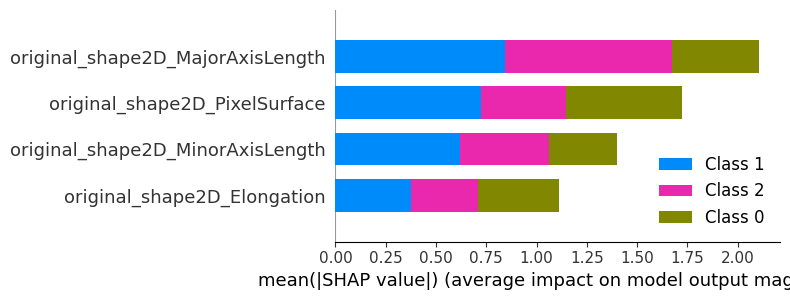

In [13]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(features)

shap.summary_plot(shap_values, features)

In [14]:
original_labels = le.inverse_transform(xgb.classes_) #fyi...
print(original_labels)

['Glioma' 'Meningioma' 'Pituitary tumor']


<Figure size 1000x600 with 0 Axes>

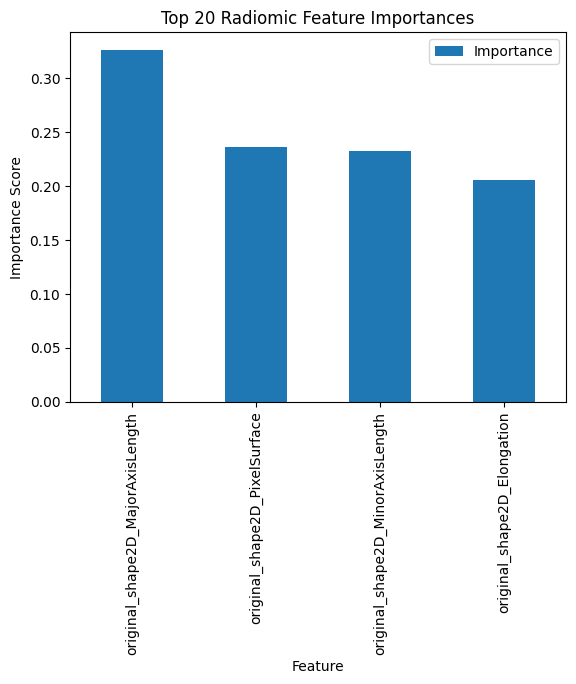

In [15]:
plt.figure(figsize=(10, 6))
top_features.head(20).plot(kind='bar', x='Feature', y='Importance')
plt.title("Top 20 Radiomic Feature Importances")
plt.ylabel("Importance Score")
plt.show()

In [16]:
F, p = f_classif(features, label)

anova_results = pd.DataFrame({
    "Feature": features.columns,    #anova also pulls out the same names as xgboost in a different order...
    "p-value": p,
    "F-score": F
}).sort_values("p-value").reset_index(drop=True)

anova_results.head(10)

Feature       p-value     F-score
0  original_shape2D_MajorAxisLength  6.741491e-80  198.359413
1  original_shape2D_MinorAxisLength  9.628051e-63  152.532227
2     original_shape2D_PixelSurface  7.823123e-60  144.921636
3       original_shape2D_Elongation  8.503676e-12   25.789673

Top features for class: 0


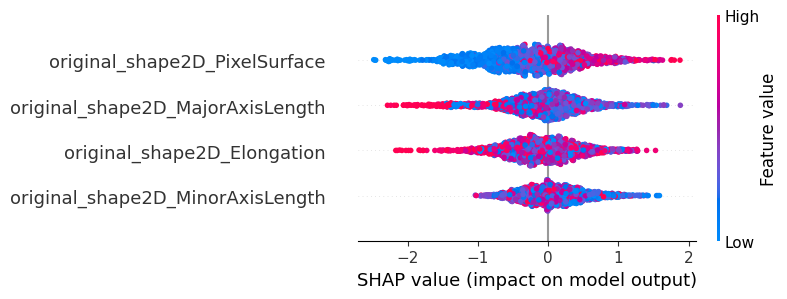

Top features for class: 1


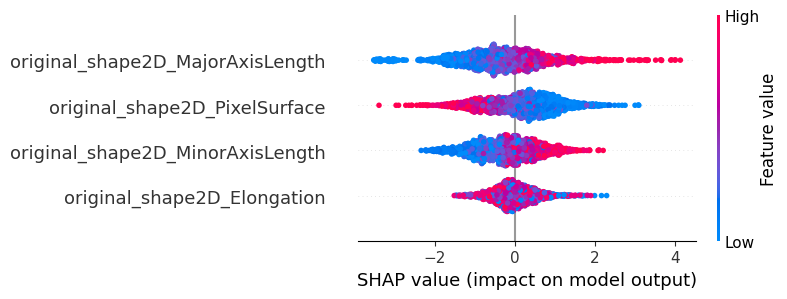

Top features for class: 2


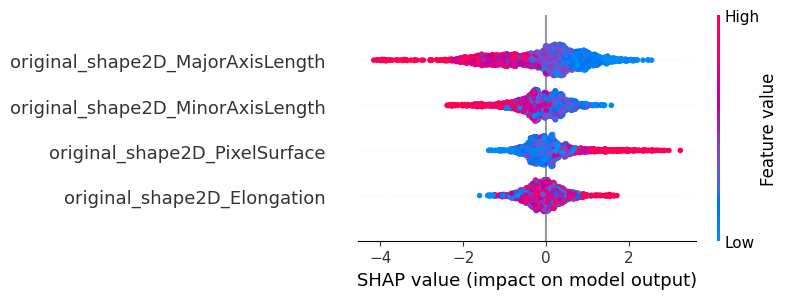

In [17]:
for shap_class, cls in zip(shap_values, xgb.classes_):
    print(f"Top features for class: {cls}")
    shap.summary_plot(shap_class, features, feature_names=features.columns)

## We can conclude that original_shape2D_MajorAxisLength, original_shape2D_MinorAxisLength, original_shape2D_PixelSurface, and original_shape2D_Elongation are the deciding factors that identifies a specific tumor based on its 2D textures.

But then what does a CNN classfier take from these ROIs (regions of interest that makes up a brain tumor identification), when it performs its own analysis looking for relevant texture features??

#### This classfication dataset has a new class 'notumor' where the classfier is expected to differentiate between healthy brains and ones with glioma, meningioma, or pituitary.

class_name
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64


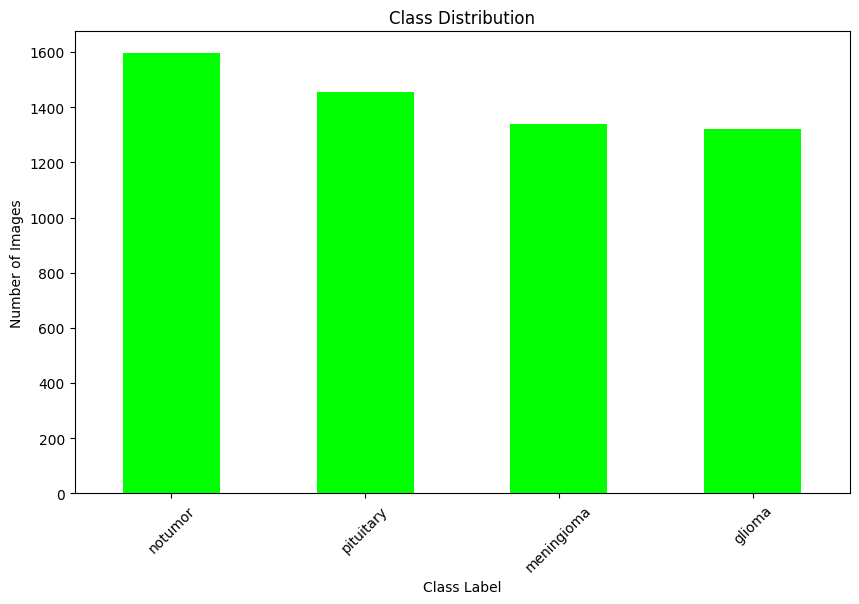

In [18]:
csv_file = "/kaggle/input/brain-tumor-classes/tumor_class_train.csv"

data_class = pd.read_csv(csv_file)

class_distribution = data_class['class_name'].value_counts()
print(class_distribution)

plt.figure(figsize=(10,6))
class_distribution.plot(kind = 'bar', color='lime')
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel("Number of Images")
plt.xticks(rotation = 45)
plt.show()

In [19]:
data_class.head()

image_path  unique_id  class_name  \
0  /kaggle/input/brain-tumor-dataset-segmentation...       2235     notumor   
1  /kaggle/input/brain-tumor-dataset-segmentation...       1781     notumor   
2  /kaggle/input/brain-tumor-dataset-segmentation...       5206      glioma   
3  /kaggle/input/brain-tumor-dataset-segmentation...       4689      glioma   
4  /kaggle/input/brain-tumor-dataset-segmentation...       4082  meningioma   

   class_id  
0         1  
1         1  
2         3  
3         3  
4         2

### **The Four Classes of Brain Tumors :**

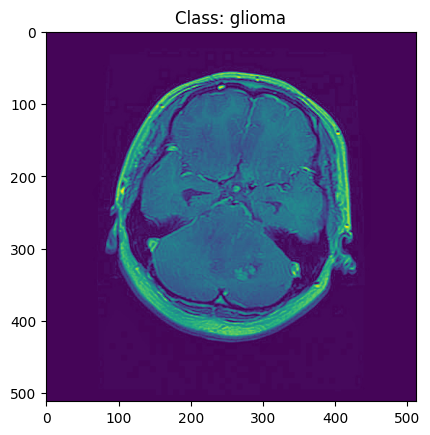

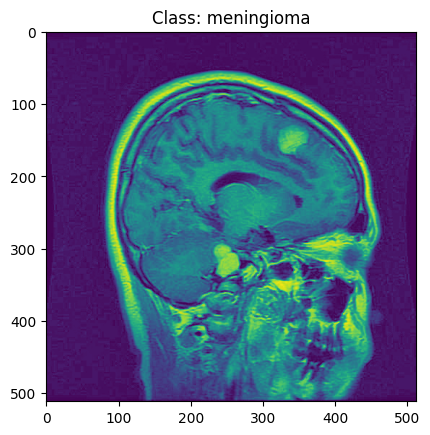

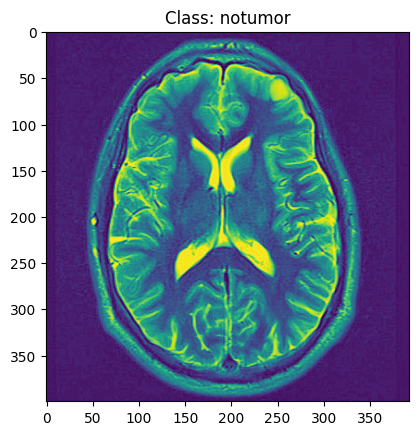

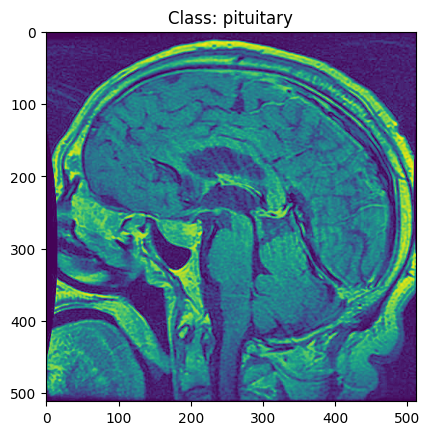

In [20]:
selected_images = data_class.groupby('class_name')['image_path'].first().reset_index()

from PIL import Image

for _, row in selected_images.iterrows():
    className = row['class_name']
    imagePath = row['image_path']
    imageFile = os.path.join('/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training', imagePath)
    image = Image.open(imageFile)

    plt.figure()
    plt.imshow(image)
    plt.title(f'Class: {className}')
    plt.show()

## Now, lets preprocess these images so we can fine tune our pre-trained CNN without background artifacts...

Pre-trained CNNs are recommend since they capture semantic features of textures better than a small custom CNN can. I learned this the hard way.

In [22]:
train_df, validate_df = train_test_split(data_class, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

batch_size = 20
img_height = 224
img_width = 224

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10, 
    rescale=1./255, 
    shear_range=0.2, 
    zoom_range=0.10, 
    horizontal_flip=True, 
    brightness_range=[1.1, 1.2]
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training",
    x_col="image_path",  
    y_col="class_name",  
    target_size=(img_height, img_width), 
    batch_size=batch_size,
    shuffle=True ,
    class_mode="categorical" 
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validate_df,
    directory="/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training",
    x_col="image_path",
    y_col="class_name",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False ,
    class_mode="categorical"
)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.


In [23]:
test_dir = '/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Testing'
test_csv_path = '/kaggle/input/brain-tumor-classes/tumor_class_test.csv'
test_df = pd.read_csv(test_csv_path)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    test_dir,
    x_col="image_path",
    y_col="class_name",
    target_size=(img_height, img_width),
    batch_size=1, #Better for plotting
    shuffle=False,
    class_mode="categorical"
)

Found 1311 validated image filenames belonging to 4 classes.


Much better for the model.

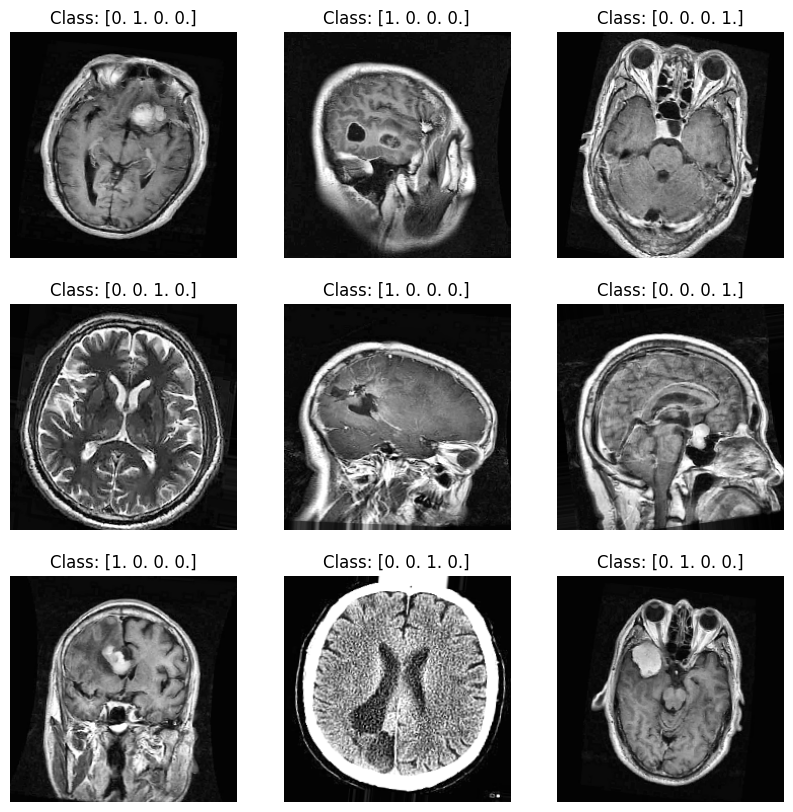

In [24]:
import matplotlib.pyplot as plt
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)   #New preprocessed MRI images
    plt.imshow(images[i])
    plt.title(f'Class: {labels[i]}')
    plt.axis('off')
plt.show()

In [25]:
class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']


## Now time to fine tune our MobileNetV2 CNN model...

In [26]:
input_shape = (img_height, img_width, 3)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False
    
num_layers_to_unfreeze = 50

for layer in base_model.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(1024, activation='relu')(x)  
predictions = Dense(4, activation='softmax')(x)  


model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(train_generator, epochs= 5, validation_data=validation_generator)

I0000 00:00:1764736057.061883      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764736057.062549      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/5


I0000 00:00:1764736070.506636   98815 service.cc:148] XLA service 0x793d34114bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764736070.507809   98815 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764736070.507833   98815 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764736072.111327   98815 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/229 ━━━━━━━━━━━━━━━━━━━━ 1:15:20 20s/step - accuracy: 0.1000 - loss: 1.7356

I0000 00:00:1764736079.696441   98815 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


229/229 ━━━━━━━━━━━━━━━━━━━━ 121s 442ms/step - accuracy: 0.7976 - loss: 0.5203 - val_accuracy: 0.8644 - val_loss: 0.3524
Epoch 2/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 64s 279ms/step - accuracy: 0.9439 - loss: 0.1524 - val_accuracy: 0.9221 - val_loss: 0.2243
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 63s 277ms/step - accuracy: 0.9628 - loss: 0.1018 - val_accuracy: 0.9256 - val_loss: 0.2184
Epoch 4/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 64s 279ms/step - accuracy: 0.9731 - loss: 0.0773 - val_accuracy: 0.9344 - val_loss: 0.2032
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 64s 279ms/step - accuracy: 0.9798 - loss: 0.0511 - val_accuracy: 0.9545 - val_loss: 0.1519


In [27]:
first_test_predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

1312/1312 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step


Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


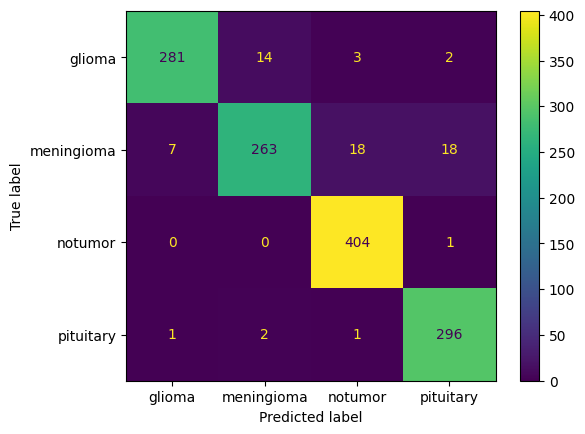

In [28]:
predicted_labels = np.argmax(first_test_predictions, axis=1)
true_labels = test_generator.classes
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot()
plt.show()

### Implementing Gradcam++

The difference bewteen Gradcam and Gradcam++ is that Gradcam++ focuses more on the pixels that make up the ROI and weighs them more, while Gradcam just puts weights on the whole ROI.

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def grad_cam_plus_plus(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(layer_name).output, model.output] #get conv layer feature maps
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_output) 

    numerator = grads ** 2
    denominator = 2 * grads ** 2 + tf.reduce_sum(conv_output * grads, axis=(1, 2), keepdims=True)   #weights on the pixels that make up the ROI  
    alpha = numerator / (denominator + 1e-10)

    weights = tf.reduce_sum(alpha * tf.nn.relu(grads), axis=(1, 2))
    cam = tf.reduce_sum(weights * conv_output, axis=-1).numpy()

    cam = np.maximum(cam, 0)
    cam = cam[0]  

    cam = cv2.resize(cam, (img_width, img_height))
    cam = cam / cam.max() #resize and normalize
    return cam

In [30]:
last_conv_layer = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer = layer.name
        break

print(last_conv_layer)

Conv_1


In [31]:
test_generator.reset() #running predictions again...

predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes 
class_names = list(test_generator.class_indices.keys())

1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


What did the CNN look for from the correct images?

In [32]:
correct_images = []
correct_pred_labels = []

test_generator.reset()

for i in range(test_generator.samples):
    img_batch = next(test_generator)[0]
    img = img_batch[0]
    
    if predicted_labels[i] == true_labels[i]: 
        correct_images.append(img)
        correct_pred_labels.append(predicted_labels[i])

    if len(correct_images) >= 1200: 
        break

In [33]:
correct_heatmaps = []

for img in correct_images:
    img_input = np.expand_dims(img, axis=0)
    heatmap = grad_cam_plus_plus(model, img_input, last_conv_layer)
    correct_heatmaps.append(heatmap)


The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))


In [34]:
def get_saliency_mask(heatmap, tumor_mask=None, percentile=90):
    
    if tumor_mask is not None:  
        night_vision = np.percentile(heatmap[tumor_mask > 0], percentile)
        saliency_mask = (heatmap > night_vision) & (tumor_mask > 0)
    else:                                                     #like the segmented masks we dont pay attention towards the background
        night_vision = np.percentile(heatmap, percentile)
        saliency_mask = (heatmap > night_vision)

    return saliency_mask.astype(np.uint8)  

In [35]:
import cv2
import numpy as np

def generate_pseudo_mask(img):
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY) #grayscale

    threshold_value, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #print("threshold:", threshold_value)

    kernel = np.ones((5, 5), np.uint8) 
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return (mask > 0).astype(np.uint8) 
    
saliency_masks = []

for i, (heatmap, pred_label) in enumerate(zip(correct_heatmaps, correct_pred_labels)):
    
    class_name = class_names[pred_label]
    
    if class_name != 'notumor': 
        tumor_mask = generate_pseudo_mask(correct_images[i]) 
    else:
        tumor_mask = None 

    mask = get_saliency_mask(heatmap, tumor_mask, percentile=90)
    saliency_masks.append(mask)

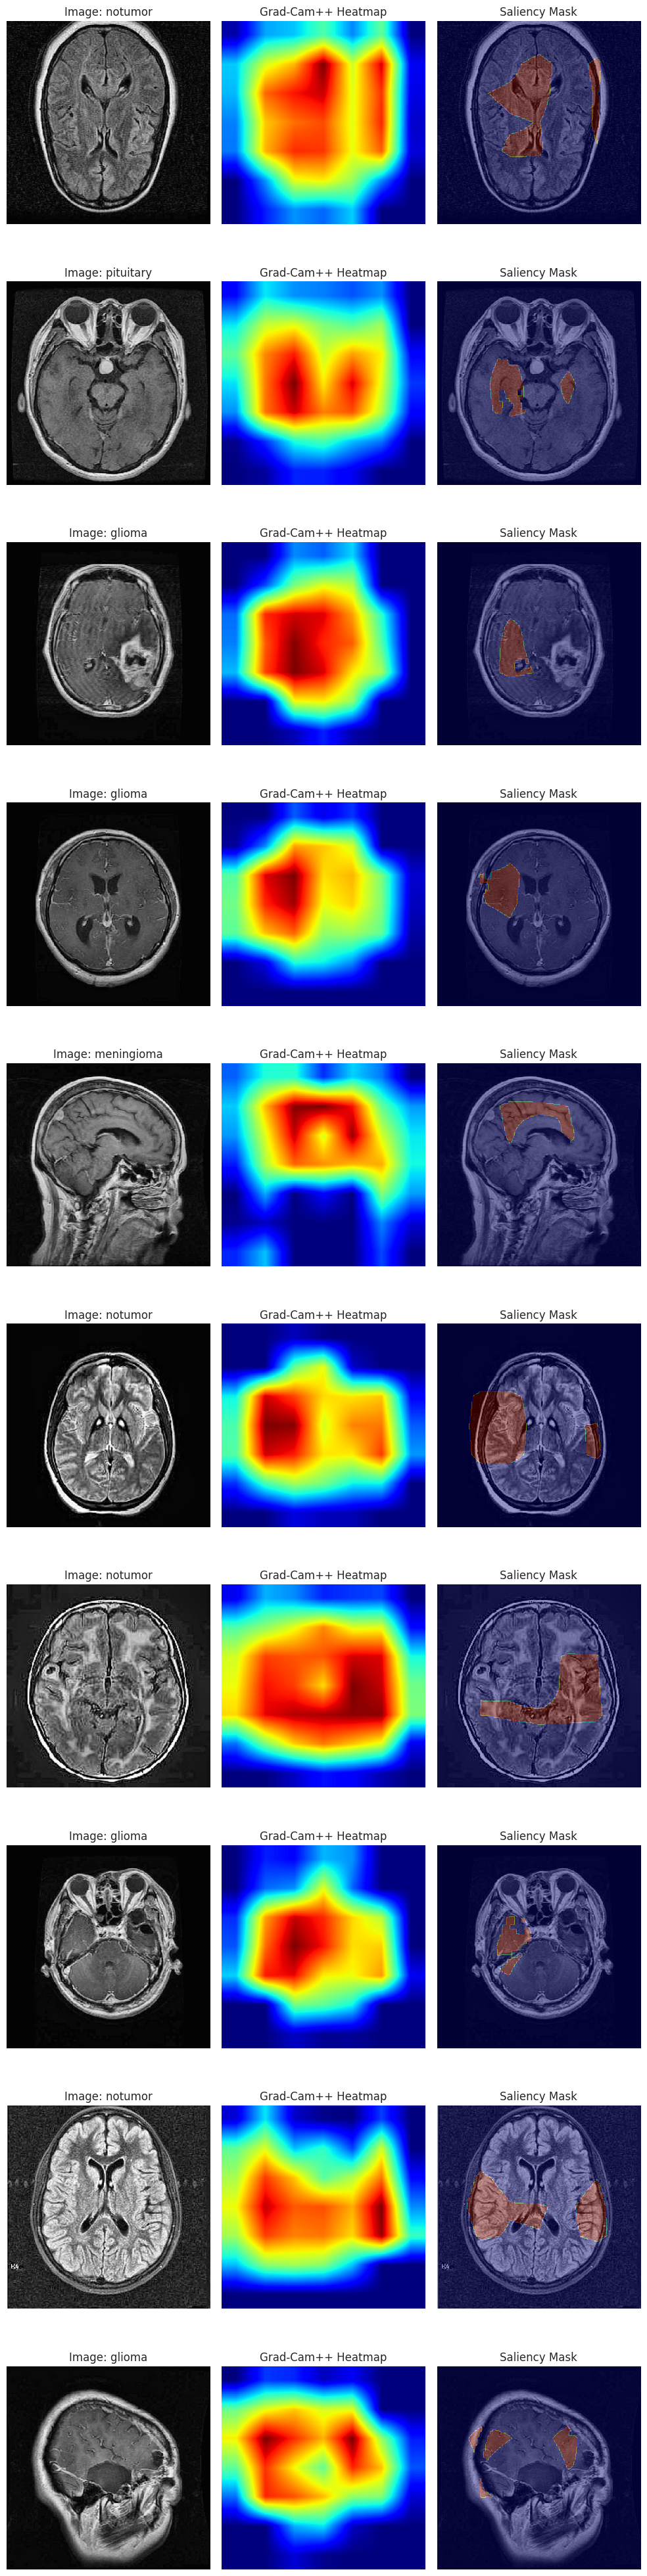

In [48]:
image_count = 10
plot_images = correct_images[:image_count]
plot_labels = correct_pred_labels[:image_count]
plot_heatmaps = correct_heatmaps[:image_count]
plot_saliency = saliency_masks[:image_count]

plt.figure(figsize=(10, 40))

for i in range(image_count):
    plt.subplot(image_count, 3, 3*i + 1)
    plt.imshow(plot_images[i])
    plt.title(f"Image: {class_names[plot_labels[i]]}")
    plt.axis('off')

    plt.subplot(image_count, 3, 3*i + 2)
    plt.imshow(plot_heatmaps[i], cmap='jet')
    plt.title("Grad-Cam++ Heatmap")
    plt.axis('off')

    plt.subplot(image_count, 3, 3*i + 3)
    plt.imshow(plot_images[i])
    plt.imshow(plot_saliency[i], alpha=0.4, cmap='jet')
    plt.title("Saliency Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

Seems to be a brief outline of the shape instead of a more proximal area...

#### Saving saliency masks as .nii files to use Pyradiomics FeatureExtractor from...

```
import cv2
import numpy as np
import nibabel as nib

def save_jpg_as_nifti(jpg_path, nii_path):
    img = cv2.imread(jpg_path, cv2.IMREAD_GRAYSCALE) 
    img = img.astype(np.float32)

    affine = np.eye(4)

    nii_img = nib.Nifti1Image(img, affine)
    nib.save(nii_img, nii_path)
    print(f"Saved MRI NIfTI: {nii_path}")
```

```
def save_mask_nifti(mask, reference_nii_path, out_path):
    ref_nii = nib.load(reference_nii_path)
    affine = ref_nii.affine 

    mask_nii = nib.Nifti1Image(mask.astype(np.uint8), affine)
    nib.save(mask_nii, out_path)
    print(f"Saved mask: {out_path}")
```

```
import os
import cv2
import numpy as np
import nibabel as nib

output_dir = "radiomics_ready/"
os.makedirs(output_dir, exist_ok=True)

def save_jpg_as_nifti(jpg_path, nii_path):
    img = cv2.imread(jpg_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

    affine = np.eye(4)            
    nii = nib.Nifti1Image(img, affine)

    nib.save(nii, nii_path)

def save_mask_nifti(mask, ref_nii_path, out_path):
    ref = nib.load(ref_nii_path)
    nii = nib.Nifti1Image(mask.astype(np.uint8), ref.affine)
    nib.save(nii, out_path)

for index, (img, heatmap, pred) in enumerate(zip(correct_images, correct_heatmaps, correct_pred_labels)):

    class_name = class_names[pred]
    jpg_path   = test_generator.filepaths[index]   
    print(f"Processing: {jpg_path}")

    mri_nii_path = os.path.join(output_dir, f"{index:03d}_{class_name}_MRI.nii.gz")
    save_jpg_as_nifti(jpg_path, mri_nii_path)

    if class_name != 'notumor':
        tumor_mask = generate_pseudo_mask(img)  
    else:
        tumor_mask = None

    saliency_mask = get_saliency_mask(heatmap, tumor_mask, percentile=90)

    mask_nii_path = os.path.join(output_dir, f"{index:03d}_{class_name}_saliency_mask.nii.gz")
    save_mask_nifti(saliency_mask, mri_nii_path, mask_nii_path)

    print(f"Saved: {mri_nii_path}  |  {mask_nii_path}")

```

In [37]:
plt.style.use('default')
sns.set_theme(style="whitegrid")

df_comparsion = pd.read_csv("/kaggle/input/brain-tumor-classes/Class_radiomics_saliency_comparison.csv")

df_comparsion.head()

ID IN_diagnostics_Versions_PyRadiomics  \
0  281_meningioma                              v3.0.1   
1    1086_notumor                              v3.0.1   
2   961_pituitary                              v3.0.1   
3   644_pituitary                              v3.0.1   
4   633_pituitary                              v3.0.1   

  IN_diagnostics_Versions_Numpy IN_diagnostics_Versions_SimpleITK  \
0                        1.26.4                             2.5.2   
1                        1.26.4                             2.5.2   
2                        1.26.4                             2.5.2   
3                        1.26.4                             2.5.2   
4                        1.26.4                             2.5.2   

  IN_diagnostics_Versions_PyWavelet IN_diagnostics_Versions_Python  \
0                             1.8.0                        3.11.13   
1                             1.8.0                        3.11.13   
2                             1.8.0                        3.11.13   
3                             1.8.0                        3.11.13   
4                             1.8.0                        3.11.13   

               IN_diagnostics_Configuration_Settings  \
0  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1  {'minimumROIDimensions': 2, 'minimumROISize': ...   
2  {'minimumROIDimensions': 2, 'minimumROISize': ...   
3  {'minimumROIDimensions': 2, 'minimumROISize': ...   
4  {'minimumROIDimensions': 2, 'minimumROISize': ...   

  IN_diagnostics_Configuration_EnabledImageTypes  \
0                               {'Original': {}}   
1                               {'Original': {}}   
2                               {'Original': {}}   
3                               {'Original': {}}   
4                               {'Original': {}}   

         IN_diagnostics_Image-original_Hash  \
0  ab6a9cf3cfecf4176dd1b942cce630d2f76e7563   
1  2f3280e51fafd0044d8ca9daee4175d652d7a63f   
2  e1fc1c45e2923a6ffad27aa7d281073c7172fb96   
3  ac739eb21f1907faa3e7db9672644431ca4800d2   
4  559c94bec070be6ba46b7be0e394d99905a51e35   

  IN_diagnostics_Image-original_Dimensionality  ...  \
0                                           2D  ...   
1                                           2D  ...   
2                                           2D  ...   
3                                           2D  ...   
4                                           2D  ...   

  OUT_original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                                         15.706091   
1                                         10.060790   
2                                         11.341236   
3                                         22.560207   
4                                         11.307750   

  OUT_original_glszm_SmallAreaLowGrayLevelEmphasis  \
0                                         0.048179   
1                                         0.043025   
2                                         0.033383   
3                                         0.052383   
4                                         0.037221   

   OUT_original_glszm_ZoneEntropy  OUT_original_glszm_ZonePercentage  \
0                        6.045411                           0.144939   
1                        6.589504                           0.048315   
2                        6.745510                           0.036315   
3                        5.988070                           0.229370   
4                        6.718142                           0.048362   

   OUT_original_glszm_ZoneVariance OUT_original_ngtdm_Busyness  \
0                     4.209920e+03                  113.905459   
1                     8.136836e+05                  313.943542   
2                     1.719737e+06                  225.327657   
3                     7.683775e+03                  164.421235   
4                     3.354986e+05                  238.444597   

  OUT_original_ngtdm_Coarseness OUT_original_ngtdm_Complexity  \
0                    

In [38]:
df_clean = df_comparsion.copy() 

diag_cols = df_clean.filter(regex='diagnostics').columns
df_clean = df_clean.drop(columns=diag_cols)

df_clean = df_clean.select_dtypes(include=['float64', 'int64'])

print(df_clean.shape)
df_clean.head()

(1181, 186)


IN_original_firstorder_10Percentile  IN_original_firstorder_90Percentile  \
0                                 14.0                                201.0   
1                                 10.0                                132.3   
2                                  5.0                                 10.0   
3                                 43.0                                226.0   
4                                 18.0                                173.0   

   IN_original_firstorder_Energy  IN_original_firstorder_Entropy  \
0                     29493343.0                        3.142933   
1                     21388354.0                        1.616190   
2                       185602.0                        0.051023   
3                     49369934.0                        3.356734   
4                     27809744.0                        3.004259   

   IN_original_firstorder_InterquartileRange  IN_original_firstorder_Kurtosis  \
0                                       91.0                         2.841603   
1                                       12.0                         6.330360   
2                                        2.0                       220.395539   
3                                      107.0                         2.053481   
4                                      108.0                         2.069682   

   IN_original_firstorder_Maximum  \
0                           255.0   
1                           241.0   
2                           108.0   
3                           255.0   
4                           238.0   

   IN_original_firstorder_MeanAbsoluteDeviation  IN_original_firstorder_Mean  \
0                                     55.454998                    86.575031   
1                                     37.110386                    39.580311   
2                                      1.975477                     8.349435   
3                                     56.853662                   140.680433   
4                                     50.446340                   100.522469   

   IN_original_firstorder_Median  ...  \
0                           69.0  ...   
1                           17.0  ...   
2                            9.0  ...   
3                          148.0  ...   
4                          111.0  ...   

   OUT_original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                                          15.706091   
1                                          10.060790   
2                                          11.341236   
3                                          22.560207   
4                                          11.307750   

   OUT_original_glszm_SmallAreaLowGrayLevelEmphasis  \
0                                          0.048179   
1                                          0.043025   
2                                          0.033383   
3                                          0.052383   
4                                          0.037221   

   OUT_original_glszm_ZoneEntropy  OUT_original_glszm_ZonePercentage  \
0                        6.045411                           0.144939   
1                        6.589504                           0.048315   
2                        6.745510                           0.036315   
3                        5.988070                           0.229370   
4                        6.718142                           0.048362   

   OUT_original_glszm_ZoneVariance  OUT_original_ngtdm_Busyness  \
0                     4.209920e+03                   113.905459   
1                     8.136836e+05                   313.943542   
2                     1.719737e+06                   225.327657   
3                     7.683775e+03                   164.421235   
4                     3.354986e+05                   238.444597   

   OUT_original_ngtdm_Coarseness  OUT_original_ngtdm_Complexity  \
0                       0.000362                      26.078800   
1                       0.000113           

In [39]:
df_clean["TumorType"] = df_comparsion["ID"].apply(lambda x: x.split("_")[1])
df_clean["TumorType"].value_counts()

TumorType
notumor       404
pituitary     300
glioma        262
meningioma    215
Name: count, dtype: int64

In [40]:
feature_cols = df_clean.filter(regex="IN_|OUT_").columns
X = df_clean[feature_cols]

selector = VarianceThreshold(threshold=0.01) 
X_reduced = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()]

df_clean = df_clean[selected_features.tolist() + ["TumorType"]]
print(df_clean.shape)

(1181, 156)


In [41]:
df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181 entries, 0 to 1180
Columns: 156 entries, IN_original_firstorder_10Percentile to TumorType
dtypes: float64(155), object(1)
memory usage: 1.4+ MB


IN_original_firstorder_10Percentile  IN_original_firstorder_90Percentile  \
0                                 14.0                                201.0   
1                                 10.0                                132.3   
2                                  5.0                                 10.0   
3                                 43.0                                226.0   
4                                 18.0                                173.0   

   IN_original_firstorder_Energy  IN_original_firstorder_Entropy  \
0                     29493343.0                        3.142933   
1                     21388354.0                        1.616190   
2                       185602.0                        0.051023   
3                     49369934.0                        3.356734   
4                     27809744.0                        3.004259   

   IN_original_firstorder_InterquartileRange  IN_original_firstorder_Kurtosis  \
0                                       91.0                         2.841603   
1                                       12.0                         6.330360   
2                                        2.0                       220.395539   
3                                      107.0                         2.053481   
4                                      108.0                         2.069682   

   IN_original_firstorder_Maximum  \
0                           255.0   
1                           241.0   
2                           108.0   
3                           255.0   
4                           238.0   

   IN_original_firstorder_MeanAbsoluteDeviation  IN_original_firstorder_Mean  \
0                                     55.454998                    86.575031   
1                                     37.110386                    39.580311   
2                                      1.975477                     8.349435   
3                                     56.853662                   140.680433   
4                                     50.446340                   100.522469   

   IN_original_firstorder_Median  ...  OUT_original_glszm_LargeAreaEmphasis  \
0                           69.0  ...                          4.257522e+03   
1                           17.0  ...                          8.141119e+05   
2                            9.0  ...                          1.720495e+06   
3                          148.0  ...                          7.702783e+03   
4                          111.0  ...                          3.359261e+05   

   OUT_original_glszm_LargeAreaHighGrayLevelEmphasis  \
0                                       5.618579e+04   
1                                       1.433032e+06   
2                                       2.650532e+06   
3                                       3.489730e+04   
4                                       9.449496e+05   

   OUT_original_glszm_LargeAreaLowGrayLevelEmphasis  \
0                                      2.240431e+03   
1                                      7.833044e+05   
2                                      1.681075e+06   
3                                      1.914697e+03   
4                                      3.138070e+05   

   OUT_original_glszm_SizeZoneNonUniformity  \
0                               1657.837817   
1                               2107.566208   
2                               1531.476453   
3                               3658.792030   
4                               2149.884738   

   OUT_original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                                          15.706091   
1                                          10.060790   
2                                          11.341236   
3                                          22.560207   
4                                          11.307750   

   OUT_original_glszm_ZoneEntropy  OUT_original_glszm_ZoneVariance  \
0                        6.045411                     4.209920e+03   
1                        

In [42]:
results = []
in_features = [f for f in df_clean.columns if f.startswith("IN_")]

for tumor in df_clean['TumorType'].unique():
    df_tumor = df_clean[df_clean['TumorType'] == tumor]

    for in_feature in in_features:
        out_feature = in_feature.replace("IN_", "OUT_")
        if out_feature not in df_tumor.columns:
            continue

        x = df_tumor[in_feature].astype(float)
        y = df_tumor[out_feature].astype(float)

        mask = (~x.isna()) & (~y.isna()) & np.isfinite(x) & np.isfinite(y)
        x_valid, y_valid = x[mask], y[mask]

        if len(x_valid) < 3:  
            results.append({
                "TumorType": tumor,
                "Feature": in_feature,
                "N_pairs": len(x_valid),
                "Wilcoxon_stat": None,
                "P_value": None,
                "Median_IN": np.median(x_valid) if len(x_valid) > 0 else None,
                "Median_OUT": np.median(y_valid) if len(y_valid) > 0 else None,
                "Effect_Direction": "Higher_IN" if np.median(x_valid) > np.median(y_valid) else "Higher_OUT"
            })
            continue

        stat, pval = wilcoxon(x_valid, y_valid)

        results.append({
            "TumorType": tumor,
            "Feature": in_feature,
            "N_pairs": len(x_valid),
            "Wilcoxon_stat": stat,
            "P_value": pval,
            "Median_IN": np.median(x_valid),
            "Median_OUT": np.median(y_valid),
            "Effect_Direction": "Higher_IN" if np.median(x_valid) > np.median(y_valid) else "Higher_OUT"
        })

results_df = pd.DataFrame(results)
results_df.head()

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in less
invali

TumorType                                    Feature  N_pairs  \
0  meningioma        IN_original_firstorder_10Percentile      215   
1  meningioma        IN_original_firstorder_90Percentile      215   
2  meningioma              IN_original_firstorder_Energy      215   
3  meningioma             IN_original_firstorder_Entropy      215   
4  meningioma  IN_original_firstorder_InterquartileRange      215   

   Wilcoxon_stat       P_value     Median_IN    Median_OUT Effect_Direction  
0          394.0  4.413606e-25  1.200000e+01  3.000000e+00        Higher_IN  
1         6762.5  4.148228e-07  1.569000e+02  1.560000e+02        Higher_IN  
2            0.0  4.998116e-37  1.454516e+07  1.641063e+09       Higher_OUT  
3         5518.0  2.543367e-11  2.326646e+00  2.559351e+00       Higher_OUT  
4         2705.5  1.830348e-22  5.400000e+01  9.600000e+01       Higher_OUT

In [43]:
results_df["EffectSize"] = np.log2((results_df["Median_IN"] + 1e-8) / 
                                   (results_df["Median_OUT"] + 1e-8))  
results_df["NegLog10P"] = -np.log10(results_df["P_value"])

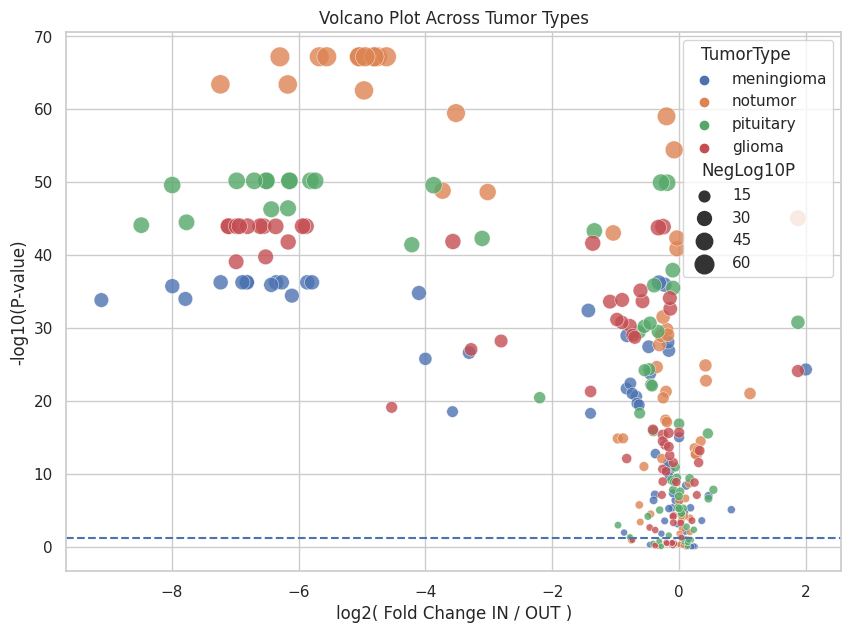

In [44]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=results_df,
    x="EffectSize",
    y="NegLog10P",
    hue="TumorType",
    size="NegLog10P",
    sizes=(20,200),
    alpha=0.8
)
plt.axhline(-np.log10(0.05), linestyle='--')
plt.title("Volcano Plot Across Tumor Types")
plt.xlabel("log2( Fold Change IN / OUT )")
plt.ylabel("-log10(P-value)")
plt.show()

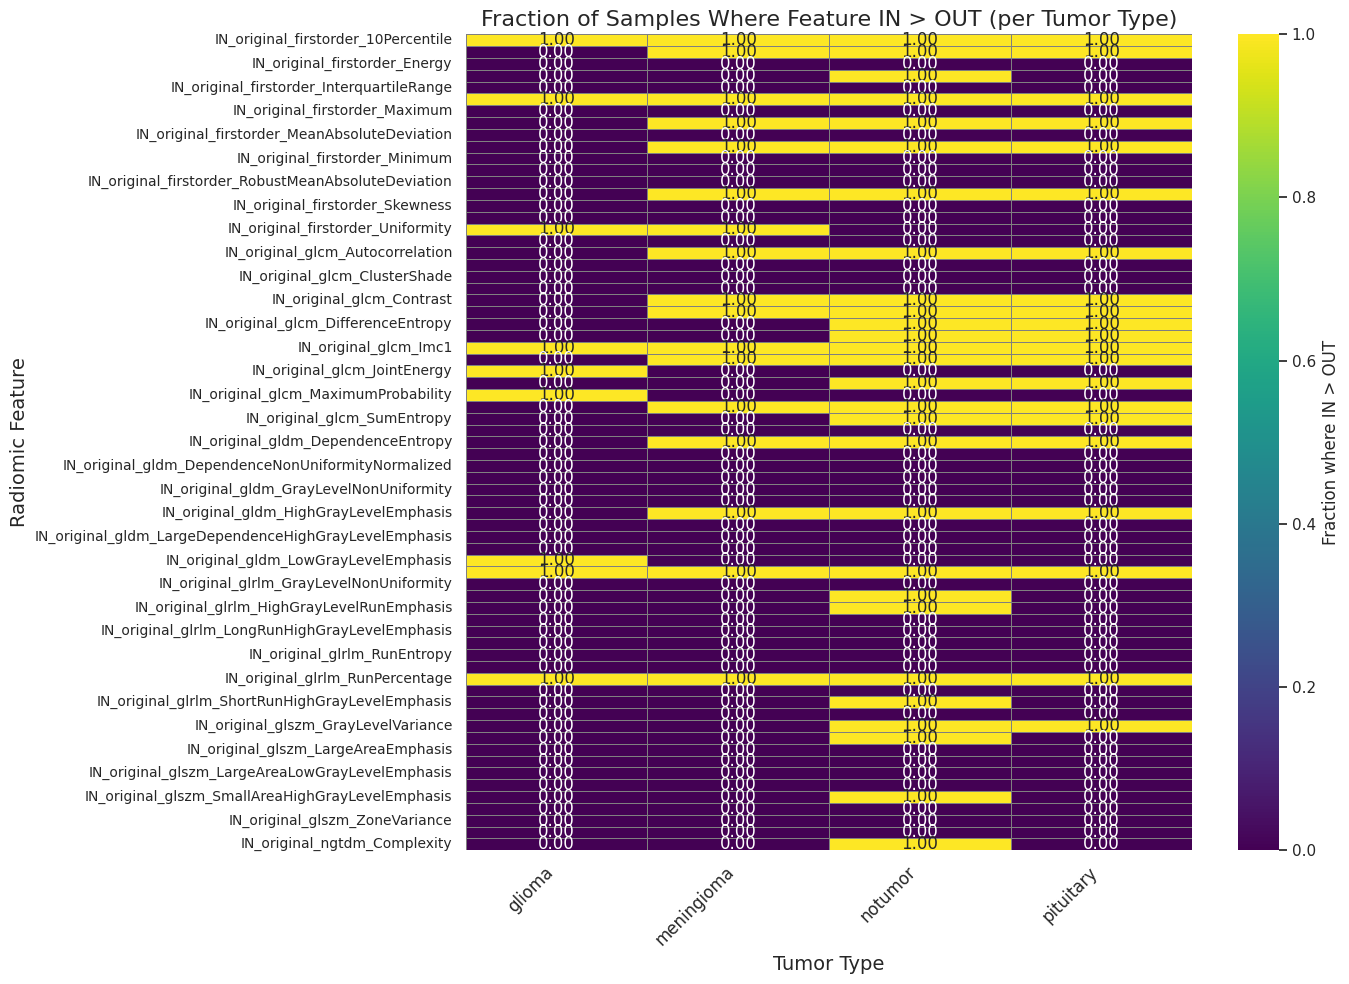

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = results_df.pivot_table(
    index="Feature", 
    columns="TumorType",
    values="Effect_Direction",
    aggfunc=lambda x: (x == "Higher_IN").mean() 
)

plt.figure(figsize=(14, 10))

sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    linecolor='gray',
    cmap="viridis", 
    cbar_kws={"label": "Fraction where IN > OUT"}
)

plt.title("Fraction of Samples Where Feature IN > OUT (per Tumor Type)", fontsize=16)
plt.xlabel("Tumor Type", fontsize=14)
plt.ylabel("Radiomic Feature", fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=10) 

plt.tight_layout()
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
The figure layout has changed to tight


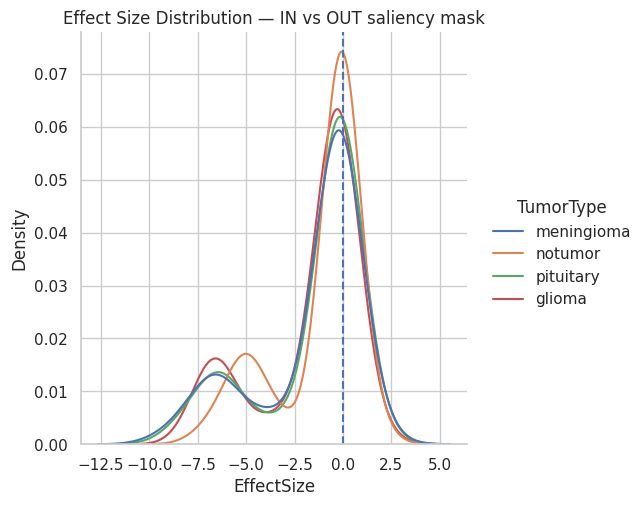

In [46]:
sns.displot(data=results_df, x="EffectSize", hue="TumorType", kind="kde")
plt.axvline(0, linestyle="--")
plt.title("Effect Size Distribution — IN vs OUT saliency mask")
plt.show()

In [47]:
sig = results_df[results_df["P_value"] < 0.01]  
strong = sig[abs(sig["EffectSize"]) > 1] 

# TOP TEXTURE BIOMARKERS PER TUMOR
top = strong.sort_values("P_value").groupby("TumorType").head(10)
top

TumorType                                   Feature  N_pairs  \
71      notumor             IN_original_firstorder_Energy      404   
84      notumor        IN_original_firstorder_TotalEnergy      404   
136     notumor                IN_original_ngtdm_Busyness      404   
132     notumor   IN_original_glszm_SizeZoneNonUniformity      404   
122     notumor  IN_original_glrlm_RunLengthNonUniformity      404   
115     notumor  IN_original_glrlm_GrayLevelNonUniformity      404   
107     notumor   IN_original_gldm_GrayLevelNonUniformity      404   
104     notumor  IN_original_gldm_DependenceNonUniformity      404   
126     notumor  IN_original_glszm_GrayLevelNonUniformity      404   
135     notumor            IN_original_glszm_ZoneVariance      404   
191   pituitary  IN_original_glrlm_RunLengthNonUniformity      300   
195   pituitary  IN_original_glszm_GrayLevelNonUniformity      300   
173   pituitary  IN_original_gldm_DependenceNonUniformity      300   
153   pituitary        IN_original_firstorder_TotalEnergy      300   
201   pituitary   IN_original_glszm_SizeZoneNonUniformity      300   
140   pituitary             IN_original_firstorder_Energy      300   
184   pituitary  IN_original_glrlm_GrayLevelNonUniformity      300   
176   pituitary   IN_original_gldm_GrayLevelNonUniformity      300   
204   pituitary            IN_original_glszm_ZoneVariance      300   
193   pituitary             IN_original_glrlm_RunVariance      300   
242      glioma  IN_original_gldm_DependenceNonUniformity      262   
245      glioma   IN_original_gldm_GrayLevelNonUniformity      262   
253      glioma  IN_original_glrlm_GrayLevelNonUniformity      262   
260      glioma  IN_original_glrlm_RunLengthNonUniformity      262   
264      glioma  IN_original_glszm_GrayLevelNonUniformity      262   
209      glioma             IN_original_firstorder_Energy      262   
222      glioma        IN_original_firstorder_TotalEnergy      262   
270      glioma   IN_original_glszm_SizeZoneNonUniformity      262   
273      glioma            IN_original_glszm_ZoneVariance      262   
274      glioma                IN_original_ngtdm_Busyness      262   
15   meningioma        IN_original_firstorder_TotalEnergy      215   
35   meningioma  IN_original_gldm_DependenceNonUniformity      215   
38   meningioma   IN_original_gldm_GrayLevelNonUniformity      215   
46   meningioma  IN_original_glrlm_GrayLevelNonUniformity      215   
2    meningioma             IN_original_firstorder_Energy      215   
53   meningioma  IN_original_glrlm_RunLengthNonUniformity      215   
57   meningioma  IN_original_glszm_GrayLevelNonUniformity      215   
63   meningioma   IN_original_glszm_SizeZoneNonUniformity      215   
67   meningioma                IN_original_ngtdm_Busyness      215   
66   meningioma            IN_original_glszm_ZoneVariance      215   

     Wilcoxon_stat       P_value     Median_IN    Median_OUT Effect_Direction  \
71             0.0  6.061596e-68  5.260142e+07  1.733918e+09       Higher_OUT   
84             0.0  6.061596e-68  5.260142e+07  1.733918e+09       Higher_OUT   
136            0.0  6.061596e-68  8.089401e+00  2.500695e+02       Higher_OUT   
132            0.0  6.061596e-68  7.490081e+01  2.098053e+03       Higher_OUT   
122            0.0  6.061596e-68  6.742543e+02  1.893271e+04       Higher_OUT   
115            0.0  6.061596e-68  2.727382e+02  7.371244e+03       Higher_OUT   
107            0.0  6.061596e-68  1.020567e+03  4.804815e+04       Higher_OUT   
104            0.0  6.061596e-68  8.355776e+02  4.270038e+04       Higher_OUT   
126            0.0  6.061596e-68  5.428235e+01  1.330278e+03       Higher_OUT   
135            3.0  6.198423e-68  5.822800e+03  4.576107e+05       Higher_OUT   
191            0.0  6.083560e-51  2.696033e+02  1.908892e+04       Higher_OUT   
195            0.0  6.083560e-51  2.546840e+01  1.361030e+03       Higher_OUT   
173            0.0  6.083560e-51  3.316655e+02  4.181668e+04       Higher_OUT   
1